In [1]:
import torch
import torchaudio
import librosa
import numpy as np

print(torch.__version__)
print(torchaudio.__version__)

import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from IPython.display import Audio, display
from data.datasets import ArcticDataset, TIMITDataset
from tqdm.notebook import tqdm

1.11.0+cu113
0.11.0+cu113


/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Utils

In [2]:
def play_audio(data: np.ndarray, rate: int) -> None:
    display(Audio(data, rate=rate))


def plot_waveform(data: np.ndarray, rate: int) -> None:
    plt.figure(figsize=(14, 5))
    plt.plot(data / 2 ** 15)
    plt.show()


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title('Spectrogram (dB)')
    axs.set_ylabel('freq bin')

    spec = spec.numpy()
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show()


def plot_mel_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Filter bank')
    axs.imshow(fbank, aspect='auto')
    axs.set_ylabel('frequency bin')
    axs.set_xlabel('mel bin')
    plt.show(block=False)

# CUDA

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset

In [4]:
vowels = ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER', 'AX', 'IX',
          'AXR', 'AH-H']

In [5]:
stops = ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q']
nasals = ['M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX']
affricates = ['JH', 'CH']
fricatives = ['S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'DH']
semivowels_glides = ['L', 'R', 'W', 'Y', 'HH', 'HV', 'EL']

In [6]:
# consonant_labels = ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q',
#                     'JH', 'CH', 'S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX']
consonants = stops + nasals + affricates + fricatives + semivowels_glides

In [34]:
phone_labels = vowels + consonants
# # phone_labels = vowel_labels
# phone_labels = ['IY', 'IH', 'EH', 'EY', 'AE', 'B', 'D', 'G', 'P', 'T',]

In [35]:
frame_rate = 16000

In [36]:
from pathlib import Path

Path('../data/timit_description.csv').exists()

True

In [11]:
from typing import Optional

class PhonemeLabeler:
    def __init__(self, phoneme_classes: dict[str, list], mode: Optional[str] = 'default'):
        self.mode = mode
        self.phoneme_classes = phoneme_classes

    def __getitem__(self, phoneme_label: str) -> str:
        if self.mode == 'default':
            return phoneme_label
        else:
            for phoneme_class, phoneme_labels in self.phoneme_classes.items():
                if phoneme_label in phoneme_labels:
                    return phoneme_class

            else:
                return phoneme_label

In [15]:
phoneme_classes = {
    'vowels': ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER', 'AX',
               'IX', 'AXR', 'AH-H'],
    'stops': ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q'],
    'nasals': ['M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX'],
    'affricates': ['JH', 'CH'],
    'fricatives': ['S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'DH'],
    'semivowels_glides': ['L', 'R', 'W', 'Y', 'HH', 'HV', 'EL']
}

PhonemeLabeler(phoneme_classes, '')['SH']

'HHH'

In [37]:
timit_dataset_vowels = TIMITDataset(usage='train',
                                    root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                    percentage=0.01,
                                    phone_codes=vowels, padding=8000,
                                    description_file_path='../data/timit_description.csv')

timit_dataset_stops = TIMITDataset(usage='train', root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                   percentage=0.01,
                                   phone_codes=stops, padding=8000,
                                   description_file_path='../data/timit_description.csv')

timit_dataset_nasals = TIMITDataset(usage='train',
                                    root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                    percentage=0.01,
                                    phone_codes=nasals, padding=8000,
                                    description_file_path='../data/timit_description.csv')

timit_dataset_affricates = TIMITDataset(usage='train',
                                        root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                        percentage=0.1,
                                        phone_codes=affricates, padding=8000,
                                        description_file_path='../data/timit_description.csv')

timit_dataset_fricatives = TIMITDataset(usage='train',
                                        root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                        percentage=0.01,
                                        phone_codes=fricatives, padding=8000,
                                        description_file_path='../data/timit_description.csv')

timit_dataset_semivowels_glides = TIMITDataset(usage='train',
                                               root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                               percentage=0.05,
                                               phone_codes=semivowels_glides, padding=8000,
                                               description_file_path='../data/timit_description.csv')

timit_dataset = TIMITDataset(usage='train', root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                             percentage=0.05,
                             phone_codes=phone_labels, padding=8000,
                             description_file_path='../data/timit_description.csv')

print(f'Length of the vowels dataset: {len(timit_dataset_vowels)}')
print(f'Length of the stops dataset: {len(timit_dataset_stops)}')
print(f'Length of the nasals dataset: {len(timit_dataset_nasals)}')
print(f'Length of the affricates dataset: {len(timit_dataset_affricates)}')
print(f'Length of the fricatives dataset: {len(timit_dataset_fricatives)}')
print(f'Length of the semivowels_glides dataset: {len(timit_dataset_semivowels_glides)}')

timit_waveform = timit_dataset_vowels[0].data
timit_framerate = timit_dataset_vowels[0].frame_rate
print(timit_waveform.shape)

Length of the vowels dataset: 555
Length of the stops dataset: 275
Length of the nasals dataset: 176
Length of the affricates dataset: 190
Length of the fricatives dataset: 220
Length of the semivowels_glides dataset: 1006
torch.Size([1, 8000])


In [38]:
sorted(list(set(datapoint.label for datapoint in timit_dataset_fricatives)))

['DH', 'F', 'S', 'SH', 'TH', 'V', 'Z', 'ZH']

# MFCC Transform

In [39]:
n_fft = 512
win_length = None
hop_length = 128
n_mels = 64
n_mfcc = 20

mfcc_transform = T.MFCC(
    sample_rate=frame_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        'n_fft': n_fft,
        'n_mels': n_mels,
        'hop_length': hop_length,
    }
)

# transform = T.Resample(orig_freq=timit_framerate, new_freq=8000) #### !!!!


AX


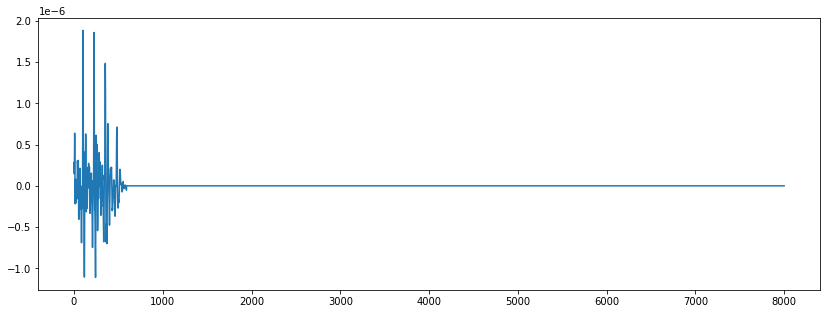

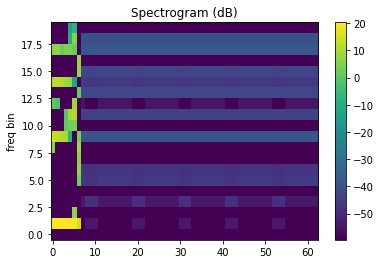

In [40]:
item = 6
timit_waveform = timit_dataset_vowels[item].data
print(timit_dataset_vowels[item].label)

play_audio(timit_waveform.numpy(), rate=frame_rate)
plot_waveform(timit_waveform.t().numpy(), rate=frame_rate)
plot_spectrogram(mfcc_transform(timit_waveform)[0])

N


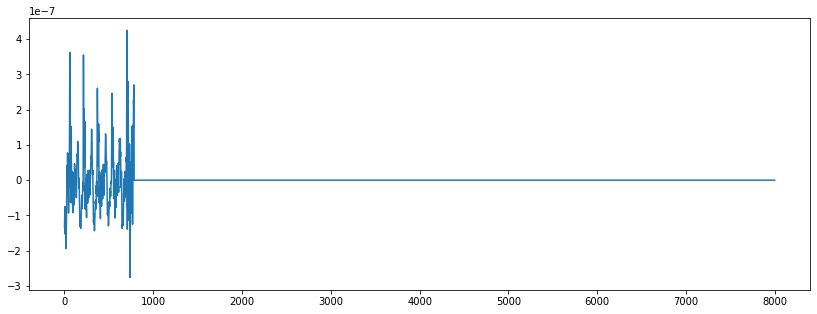

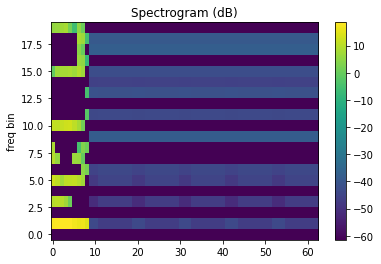

In [41]:
item = 4
timit_waveform = timit_dataset_nasals[item].data
print(timit_dataset_nasals[item].label)

play_audio(timit_waveform.numpy(), rate=frame_rate)
plot_waveform(timit_waveform.t().numpy(), rate=frame_rate)
plot_spectrogram(mfcc_transform(timit_waveform)[0])

## Feature extraction

In [42]:
mfcc_vowels_data = np.stack([mfcc_transform(waveform.data).squeeze(0).flatten() for waveform in timit_dataset_vowels],
                            axis=0)
mfcc_vowels_labels = [waveform.label for waveform in timit_dataset_vowels]

mfcc_stops_data = np.stack([mfcc_transform(waveform.data).squeeze(0).flatten() for waveform in timit_dataset_stops],
                           axis=0)
mfcc_stops_labels = [waveform.label for waveform in timit_dataset_stops]

mfcc_affricates_data = np.stack(
    [mfcc_transform(waveform.data).squeeze(0).flatten() for waveform in timit_dataset_affricates], axis=0)
mfcc_affricates_labels = [waveform.label for waveform in timit_dataset_affricates]

mfcc_fricatives_data = np.stack(
    [mfcc_transform(waveform.data).squeeze(0).flatten() for waveform in timit_dataset_fricatives], axis=0)
mfcc_fricatives_labels = [waveform.label for waveform in timit_dataset_fricatives]

mfcc_nasals_data = np.stack([mfcc_transform(waveform.data).squeeze(0).flatten() for waveform in timit_dataset_nasals],
                            axis=0)
mfcc_nasals_labels = [waveform.label for waveform in timit_dataset_nasals]

mfcc_semivowels_glides_data = np.stack(
    [mfcc_transform(waveform.data).squeeze(0).flatten() for waveform in timit_dataset_semivowels_glides], axis=0)
mfcc_semivowels_glides_labels = [waveform.label for waveform in timit_dataset_semivowels_glides]

mfcc_phones = np.stack([mfcc_transform(waveform.data).squeeze(0).flatten() for waveform in timit_dataset], axis=0)
mfcc_phones_labels = [waveform.label for waveform in timit_dataset]

## Embedding

In [43]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def get_embeddings(mfcc_data: np.ndarray, perplexity: int = 5) -> np.ndarray:
    return TSNE(
        n_components=2,
        perplexity=perplexity,
        init='pca',
        learning_rate='auto').fit_transform(mfcc_data)


def plot_embedding(data, labels, color_map, title: str, figsize: tuple = (15, 15)):
    data = MinMaxScaler().fit_transform(data)
    fig, ax = plt.subplots(figsize=figsize)
    for idx, label in enumerate(labels):
        try:
            ax.scatter(
                *data[idx],
                marker=f'${label}$',
                s=60,
                color=color_map[label]
            )
        except KeyError as err:
            print(f'{err}: label {label} is absent')
    ax.legend(color_map)
    ax.set_title(title)

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


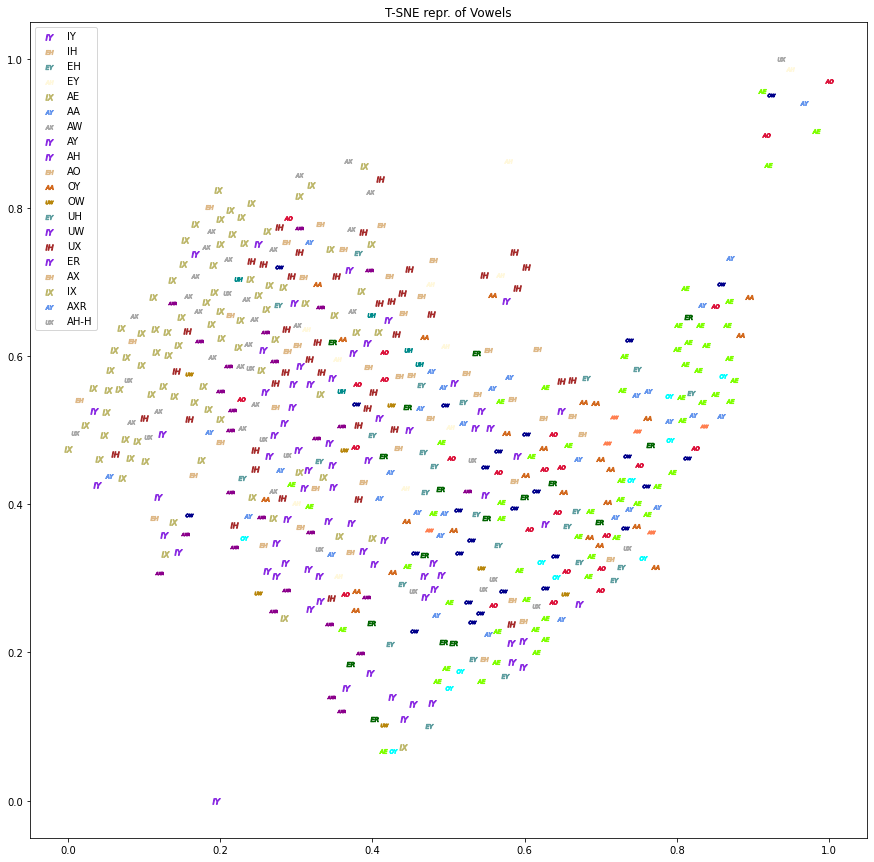

In [52]:
colors = list(mcolors.CSS4_COLORS.values())[10:len(vowels) + 10]
# colors = ['darkorange', 'brown', 'red', 'blue', 'black', 'green', 'yellow', 'deepskyblue', 'lime', 'dimgrey']
color_map = {k: v for k, v in zip(vowels, colors)}

plot_embedding(get_embeddings(mfcc_vowels_data, perplexity=50), mfcc_vowels_labels, color_map, 'T-SNE repr. of Vowels')

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


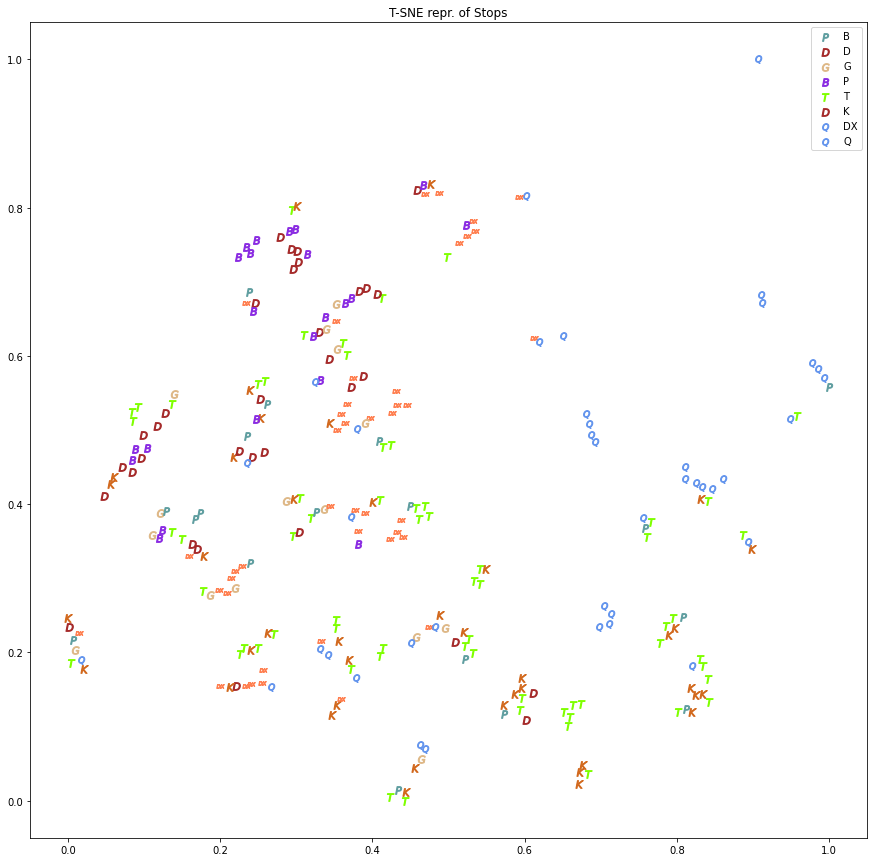

In [45]:
colors = list(mcolors.CSS4_COLORS.values())[10:len(stops) + 10]
# colors = ['darkorange', 'brown', 'red', 'blue', 'black', 'green', 'yellow', 'deepskyblue', 'lime', 'dimgrey']
color_map = {k: v for k, v in zip(stops, colors)}

plot_embedding(get_embeddings(mfcc_stops_data), mfcc_stops_labels, color_map, 'T-SNE repr. of Stops')

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


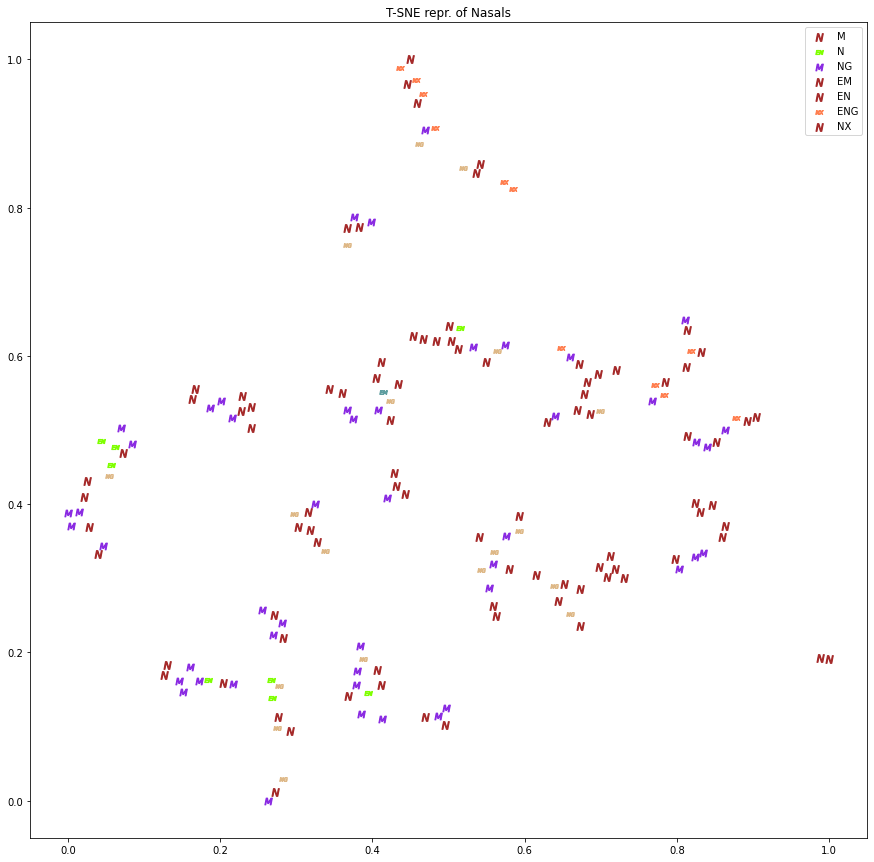

In [46]:
colors = list(mcolors.CSS4_COLORS.values())[10:len(nasals) + 10]
# colors = ['darkorange', 'brown', 'red', 'blue', 'black', 'green', 'yellow', 'deepskyblue', 'lime', 'dimgrey']
color_map = {k: v for k, v in zip(nasals, colors)}

plot_embedding(get_embeddings(mfcc_nasals_data), mfcc_nasals_labels, color_map, 'T-SNE repr. of Nasals')

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


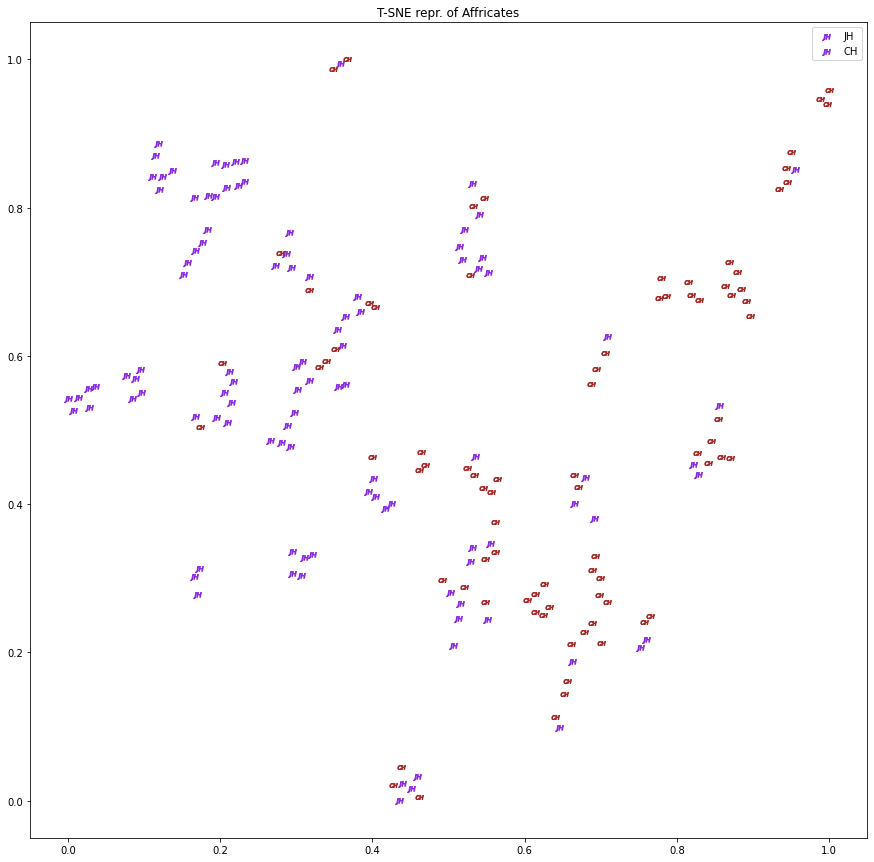

In [47]:
colors = list(mcolors.CSS4_COLORS.values())[10:len(affricates) + 10]
# colors = ['darkorange', 'brown', 'red', 'blue', 'black', 'green', 'yellow', 'deepskyblue', 'lime', 'dimgrey']
color_map = {k: v for k, v in zip(affricates, colors)}

plot_embedding(get_embeddings(mfcc_affricates_data), mfcc_affricates_labels, color_map, 'T-SNE repr. of Affricates')

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


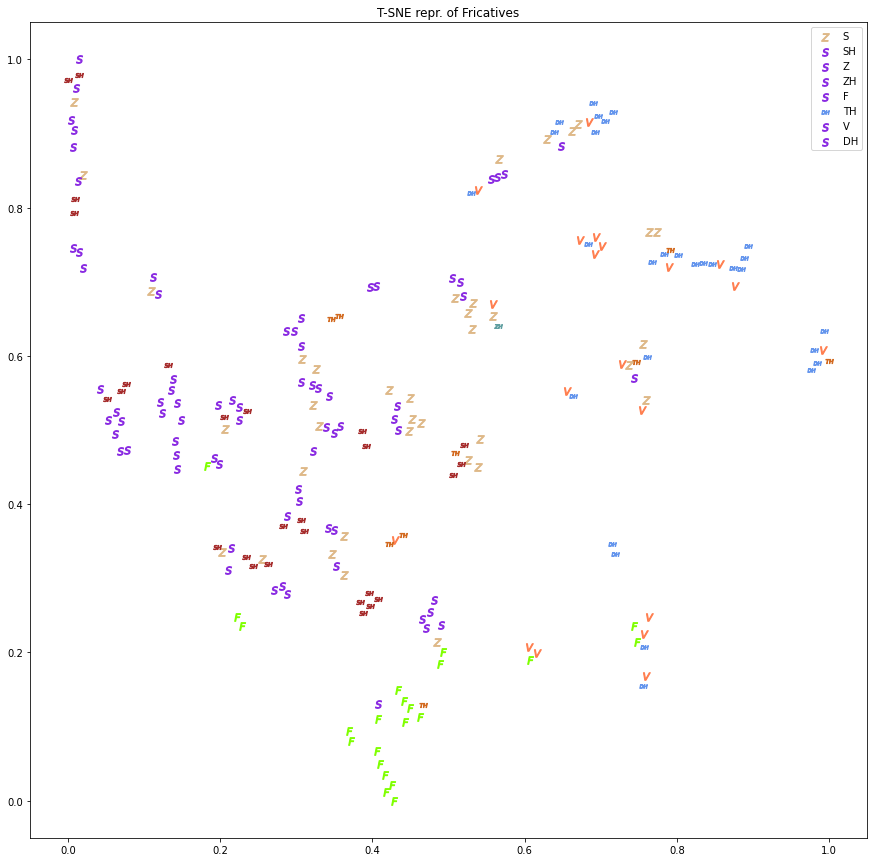

In [48]:
colors = list(mcolors.CSS4_COLORS.values())[10:len(fricatives) + 10]
# colors = ['darkorange', 'brown', 'red', 'blue', 'black', 'green', 'yellow', 'deepskyblue', 'lime', 'dimgrey']
color_map = {k: v for k, v in zip(fricatives, colors)}

plot_embedding(get_embeddings(mfcc_fricatives_data), mfcc_fricatives_labels, color_map,
               title='T-SNE repr. of Fricatives')

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


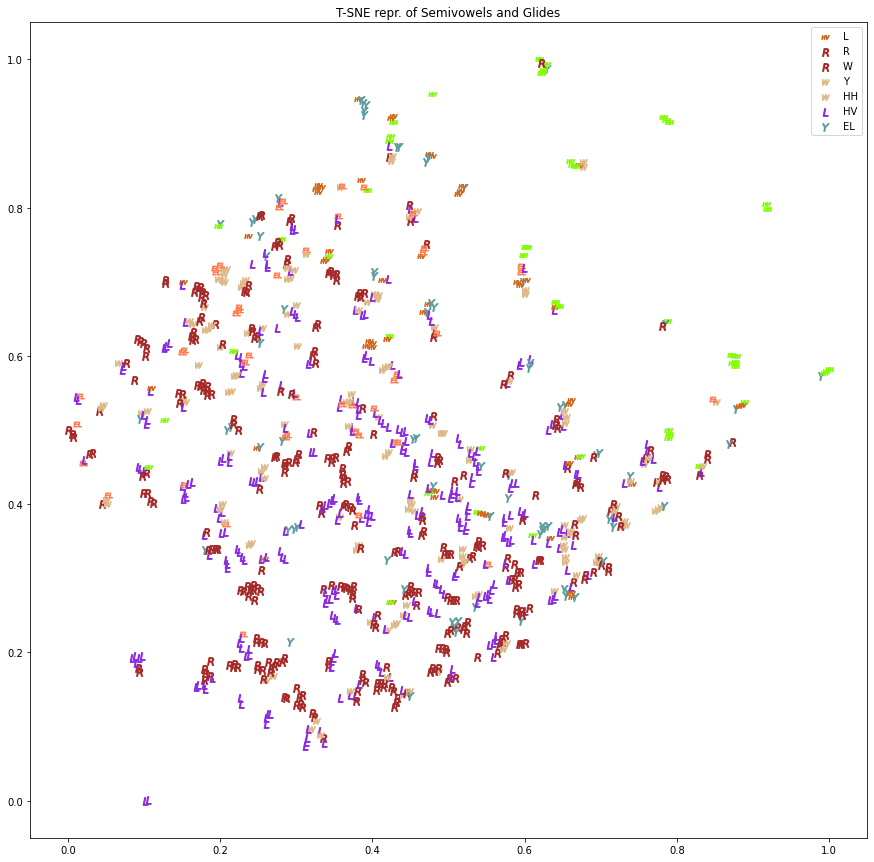

In [49]:
colors = list(mcolors.CSS4_COLORS.values())[10:len(semivowels_glides) + 10]
# colors = ['darkorange', 'brown', 'red', 'blue', 'black', 'green', 'yellow', 'deepskyblue', 'lime', 'dimgrey']
color_map = {k: v for k, v in zip(semivowels_glides, colors)}

plot_embedding(get_embeddings(mfcc_semivowels_glides_data), mfcc_semivowels_glides_labels, color_map,
               'T-SNE repr. of Semivowels and Glides')

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


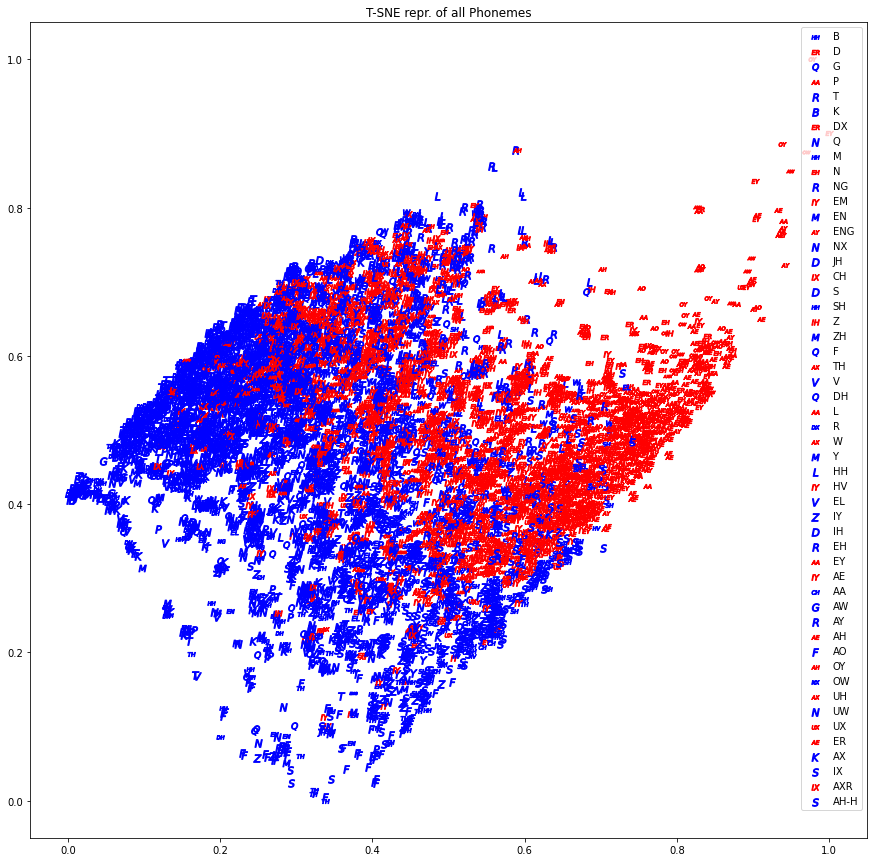

In [53]:
# colors = ['darkorange', 'brown', 'red', 'blue', 'black', 'green', 'yellow', 'deepskyblue', 'lime', 'dimgrey']

cons_color = dict.fromkeys(consonants, 'blue')
vow_color = dict.fromkeys(vowels, 'red')
color_map = {**cons_color, **vow_color}

plot_embedding(get_embeddings(mfcc_phones, perplexity=50), mfcc_phones_labels, color_map, 'T-SNE repr. of all Phonemes')

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


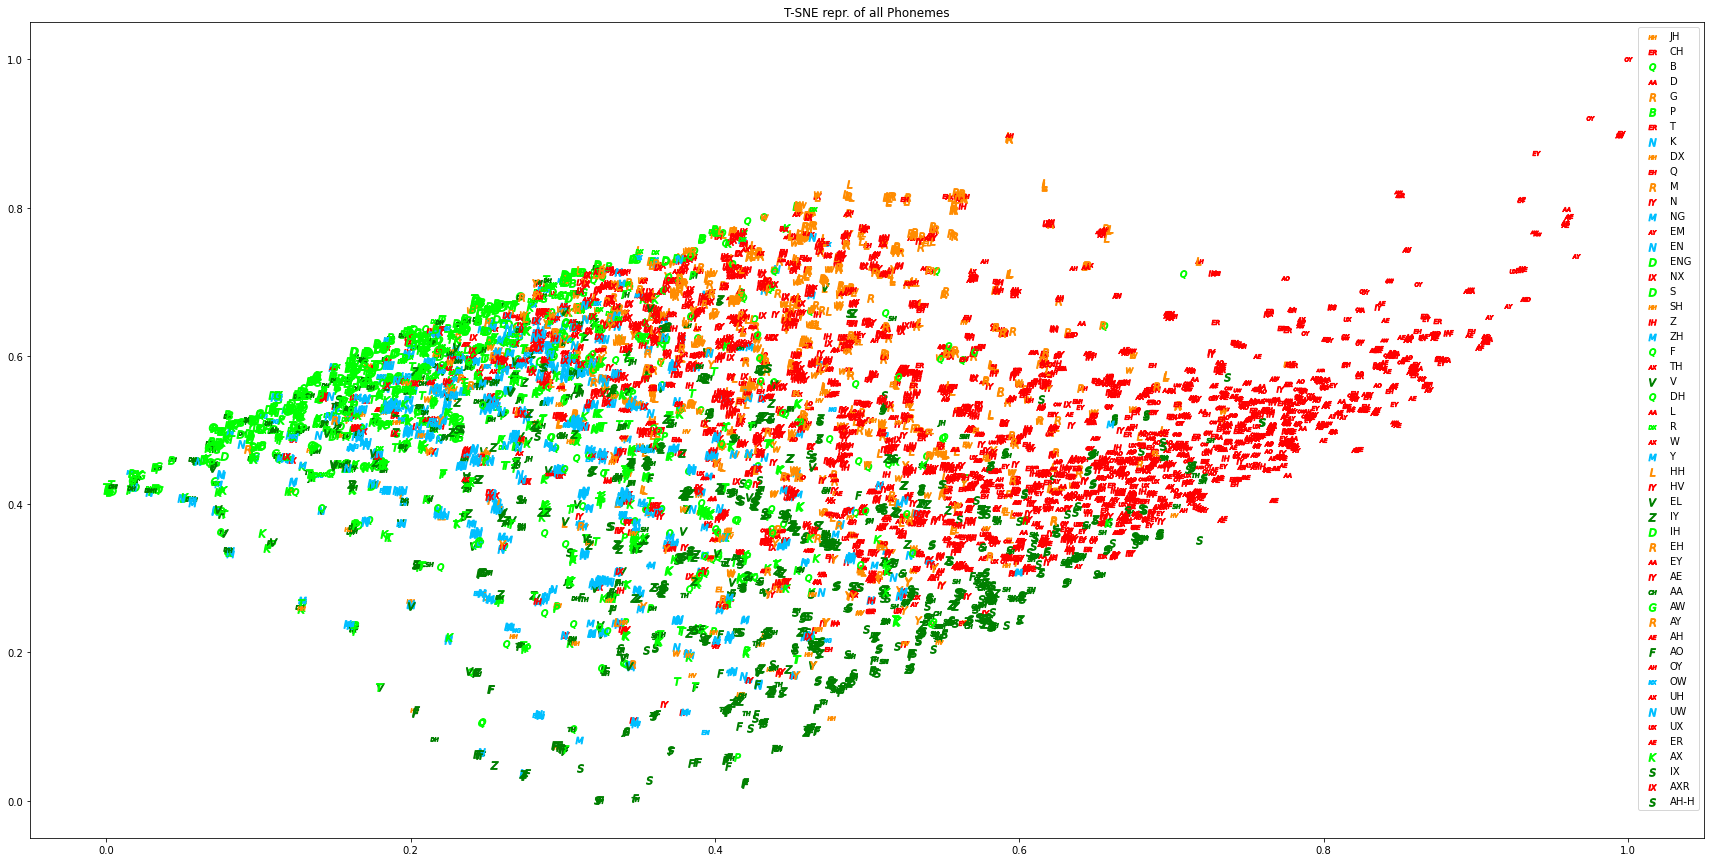

In [51]:
# colors = ['darkorange', 'brown', 'red', 'blue', 'black', 'green', 'yellow', 'deepskyblue', 'lime', 'dimgrey']

vow_color = dict.fromkeys(vowels, 'red')
affricates_color = dict.fromkeys(affricates, 'brown')
fricatives_color = dict.fromkeys(consonants, 'green')
stops_color = dict.fromkeys(stops, 'lime')
nasals_color = dict.fromkeys(nasals, 'deepskyblue')
semivowels_glides_color = dict.fromkeys(semivowels_glides, 'darkorange')
color_map = {**affricates_color, **fricatives_color, **stops_color, **nasals_color, **semivowels_glides_color,
             **vow_color}

plot_embedding(get_embeddings(mfcc_phones), mfcc_phones_labels, color_map, 'T-SNE repr. of all Phonemes',
               figsize=(30, 15))